https://finance.naver.com/sise/sise_index.naver?code=KPI200

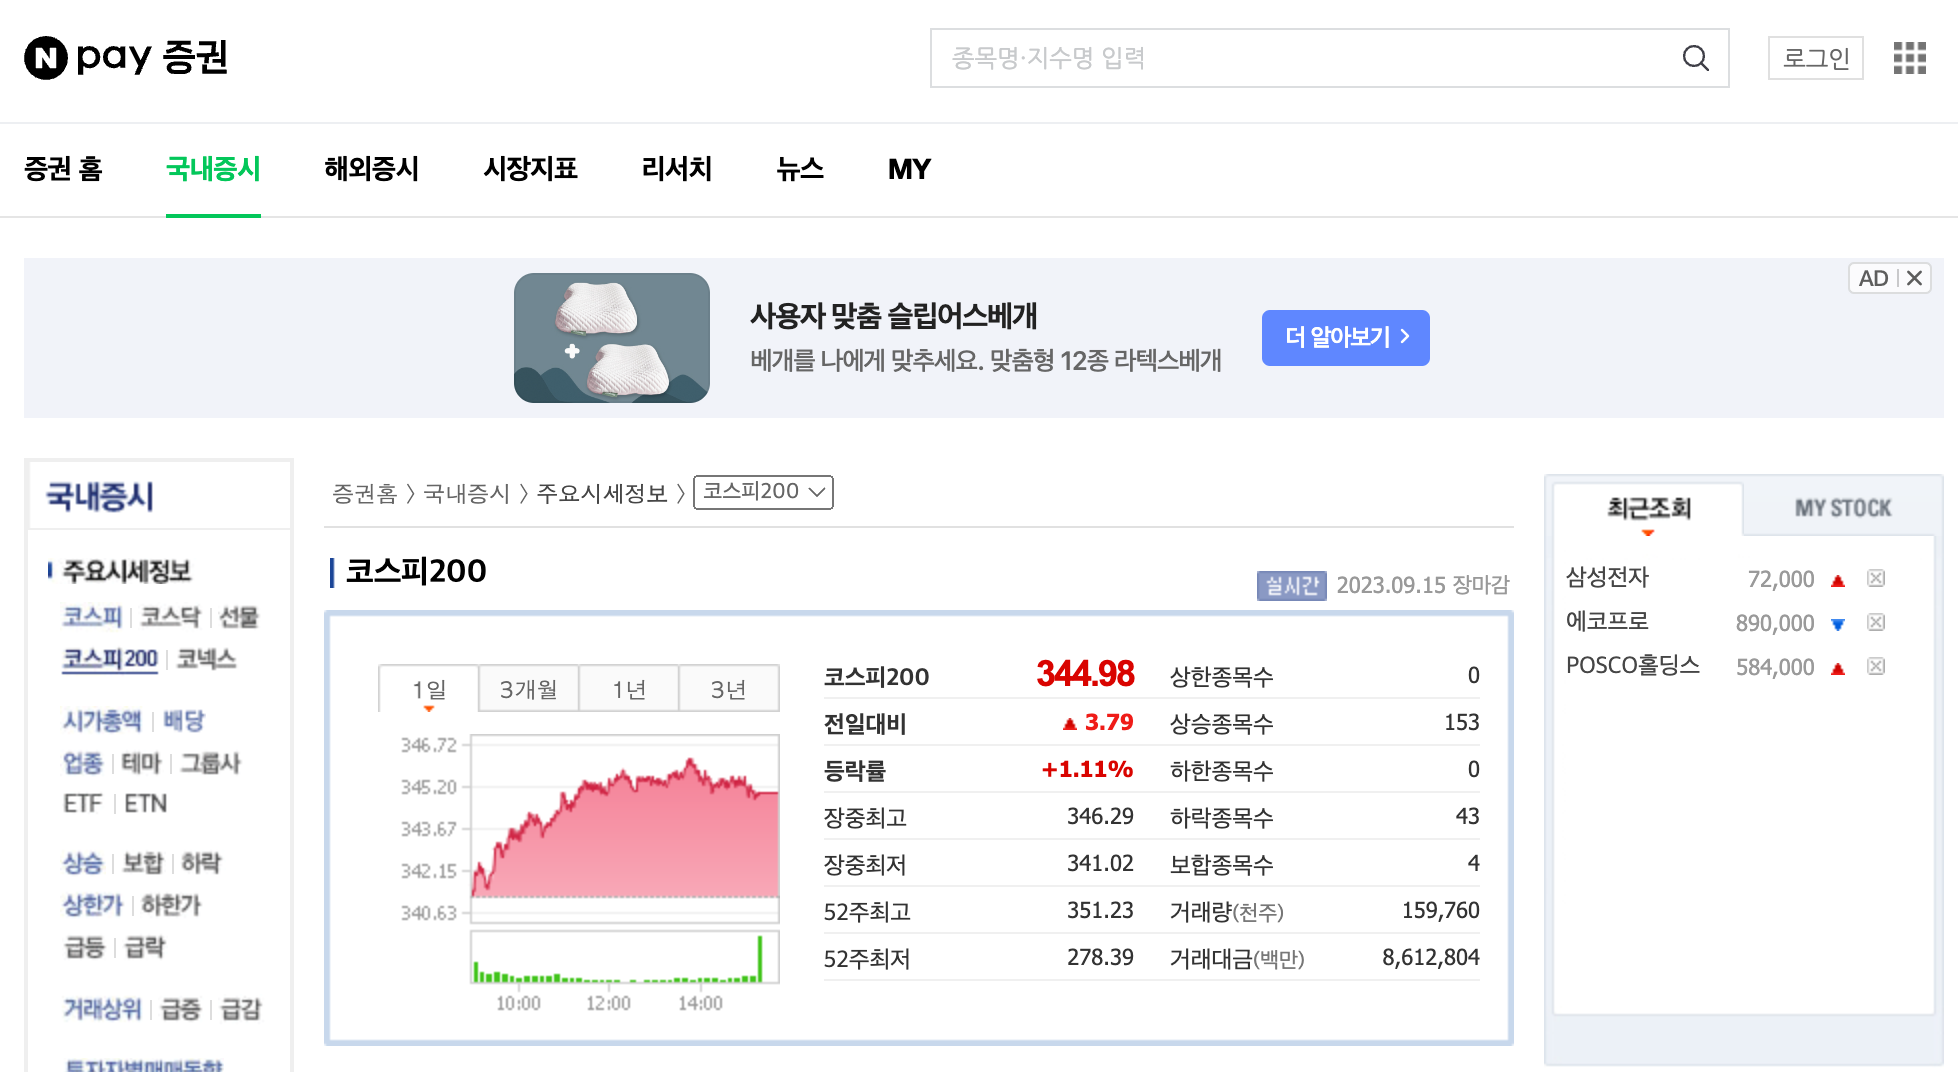

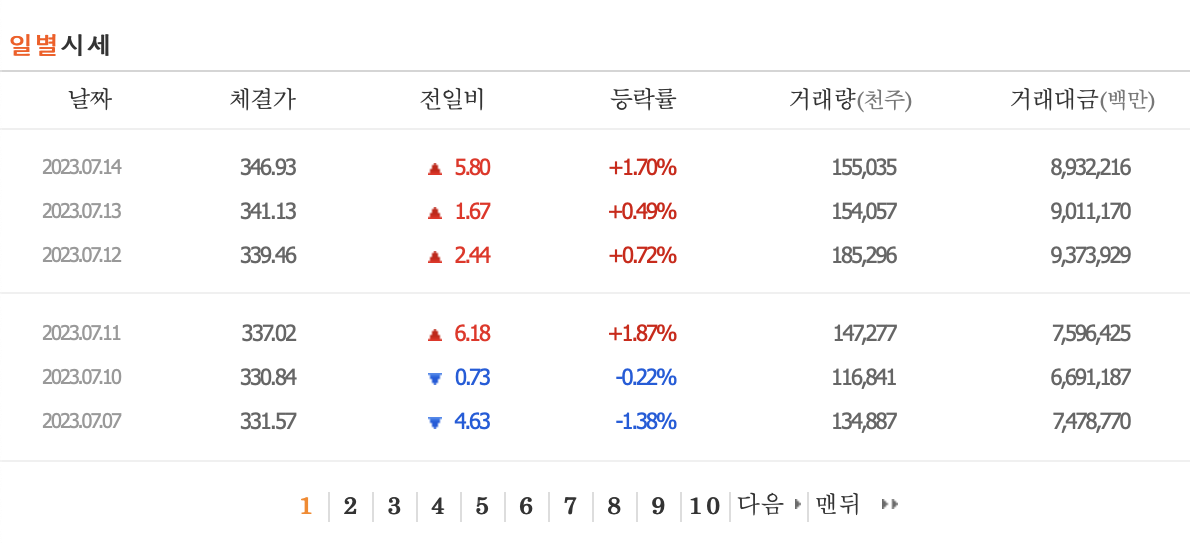

In [1]:
url = 'https://finance.naver.com/sise/sise_index_day.naver?code=KPI200'

In [2]:
param = {
    'code': 'KPI200',
}

In [ ]:
index_cd = 'KPI200'
page_n = 1
url = 'https://finance.naver.com/sise/sise_index_day.naver?code=' + index_cd + '&page=' + str(page_n)

In [ ]:
import requests
source = requests.get(naver_index).text
source

In [ ]:
import bs4
source = bs4.BeautifulSoup(source, 'lxml')

In [ ]:
print(source.prettify())

In [ ]:
td = source.find_all('td')
len(td)

날짜 추출

In [ ]:
# /html/body/div/table[1]/tbody/tr[3]/td[1]
source.find_all('table')[0].find_all('tr')[2].find_all('td')[0]


In [ ]:
d = source.find_all('td', class_='date')[0].text
d

날짜정보를  date 타입으로 변경하는 함수 정의

In [ ]:
import pandas as pd

In [ ]:
def date_format(d=''):
    if d != '':
        this_date = pd.to_datetime(d).date()
    else:
        this_date = pd.Timestamp.today().date()   # 오늘 날짜를 지정
    return (this_date)

종가 추출

In [ ]:
# /html/body/div/table[1]/tbody/tr[3]/td[2]

In [ ]:
this_close = source.find_all('tr')[2].find_all('td')[1].text
this_close = this_close.replace(',', '')
this_close = float(this_close)
this_close

In [ ]:
p = source.find_all('td', class_='number_1')[0].text
p

페이지 상의 날짜와 종가정보 전체 추출

In [ ]:
dates = source.find_all('td', class_='date')
prices = source.find_all('td', class_='number_1')

In [ ]:
len(dates)

In [ ]:
len(prices)

In [ ]:
for n in range(len(dates)):
    this_date = dates[n].text
    this_date = date_format(this_date)

    this_close = prices[n*4].text
    # 0, 4, 8, ... 4의 배수로 돌아가는 가격 추출
    this_close = this_close.replace(',', '')
    this_close = float(this_close)
    this_close

    print(this_date, this_close)

# 페이지 네비게이션 (다음페이지도 가져오기)

마지막 페이지 번호 찾기

In [ ]:
# /html/body/div/table[2]/tbody/tr/td[7]/a

In [ ]:
paging = source.find('td', class_='pgRR').find('a')['href']
paging

In [ ]:
paging = paging.split('&')[1]
paging

In [ ]:
paging = paging.split('=')[1]
paging

In [ ]:
# 페이지 번호를 찍어서 보내는 URL
naver_index = 'http://finance.naver.com/sise/sise_index_day.nhn?code=' + index_cd + '&page=' + str(722)

source = requests.get(naver_index).text
source = bs4.BeautifulSoup(source, 'lxml')

if source.find('td', class_='pgRR'):
    last_page = source.find('td', class_='pgRR').find('a')['href']
    last_page = last_page.split('&')[1]
    last_page = last_page.split('=')[1]
    last_page = int(last_page)

print(last_page)

특정 일자를 지정해서 인덱스를 추출하는 함수 정의

In [ ]:
def historical_index_naver(index_cd, start_date='', end_date='', page_n=1, last_page=0):

    end_date = date_format(end_date)
    if start_date == '':
        start_date = end_date - pd.DateOffset(years=1)
    start_date = date_format(start_date)

    naver_index = 'http://finance.naver.com/sise/sise_index_day.nhn?code=' + index_cd + '&page=' + str(page_n)

    source = requests.get(naver_index).text   # 지정한 페이지에서 코드 읽기
    source = bs4.BeautifulSoup(source, 'lxml')   # 뷰티풀 스프로 태그별로 코드 분류

    dates = source.find_all('td', class_='date')   # <td class="date">태그에서 날짜 수집
    prices = source.find_all('td', class_='number_1')   # <td class="number_1">태그에서 지수 수집

    for n in range(len(dates)):

        if dates[n].text.split('.')[0].isdigit():

            # 날짜 처리
            this_date = dates[n].text
            this_date = date_format(this_date)

            if this_date <= end_date and this_date >= start_date:
            # start_date와 end_date 사이에서 데이터 저장
                # 종가 처리
                this_close = prices[n*4].text   # prices 중 종가지수인 0,4,8,...번째 데이터 추출
                this_close = this_close.replace(',', '')
                this_close = float(this_close)

                # 딕셔너리에 저장
                historical_prices[this_date] = this_close

            elif this_date < start_date:
            # start_date 이전이면 함수 종료
                return historical_prices

    # 페이지 네비게이션
    if last_page == 0:
        last_page = source.find('td', class_='pgRR').find('a')['href']
        # 마지막페이지 주소 추출
        last_page = last_page.split('&')[1]   # & 뒤의 page=723 부분 추출
        last_page = last_page.split('=')[1]   # = 뒤의 페이지번호만 추출
        last_page = int(last_page)   # 숫자형 변수로 변환

    # 다음 페이지 호출
    if page_n < last_page:
        page_n = page_n + 1
        historical_index_naver(index_cd, start_date, end_date, page_n, last_page)

    return historical_prices

In [ ]:
index_cd = 'KPI200'
historical_prices = dict()
historical_index_naver(index_cd, '2023-08-01', '2023-09-15')
historical_prices